# 4. Simulating concept drifts with the DriftStream API

This tutorial demonstrates how to use the DriftStream API in CapyMOA:

* We start by showing how one can use a synthetic generator without concept drift (RandomTreeGenerator).
* We delve into the two API proposals for the DriftStream API, one of which has been implemented already:
    * **DriftStream Position**: **`drift position` + `drift width`** (ready!).
    * **DriftStream Range**: **`concept num_instances` + `drift num_instances`** (_Under construction_).
* More advanced examples can be found in **Tutorial 6**: Exploring Advanced Features, such as configuring and manipulating MOA streams directly.

---

*More information about CapyMOA can be found at* https://www.capymoa.org.

**last update on 28/11/2025**

## 4.1 CapyMOA synthetic generators

* In this example, we show how to use `RandomTreeGenerator` to generate a synthetic stream.

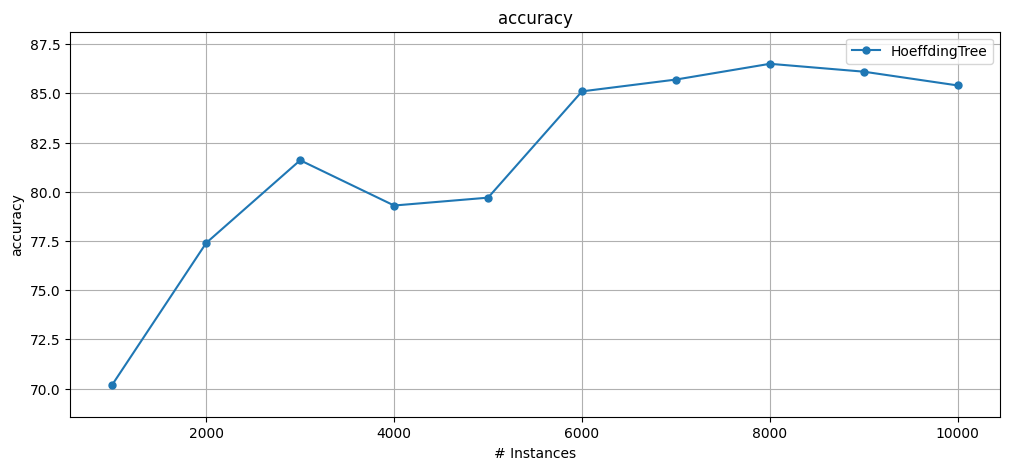

In [1]:
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import HoeffdingTree

rtg_stream = RandomTreeGenerator()

ht = HoeffdingTree(schema=rtg_stream.get_schema())

results_ht = prequential_evaluation(
    max_instances=10000, window_size=1000, stream=rtg_stream, learner=ht
)

plot_windowed_results(results_ht, metric="accuracy")

## 4.2 CapyMOA DriftStream builder API

* MOA uses a recursive approach to specify concept drift locations like ```CDS(CDS(SEA(1), SEA(2), 1000), SEA(3), 2000)``` where we specify the drift **position** and the **width** of a drift (if it is a Gradual Drift).

In CapyMOA, the concepts and drifts are clearly outlined on a list format. There are two ways of specifying a DriftStream in this list format:

1. **DriftStream Position**: **```drift position``` + ```drift width```**: the start and end of a concept is determined by the presence of an ```AbruptDrift``` or ```GradualDrift``` object.
   
    <!-- ```[SEA(1), AbruptDrift(position=1000), SEA(2), GradualDrift(position=2000, width=500), SEA(3)]``` -->

    * **DriftStream([**
        * <span style="color:blue;">SEA(1)</span>,
        * <span style="color:red;">AbruptDrift(position=1000)</span>, 
        * <span style="color:blue;">SEA(2)</span>, 
        * <span style="color:green;">GradualDrift(<b>position</b>=2000, <b>width</b>=500)</span>, 
        * <span style="color:blue;">SEA(3)</span>**])**

* The ```GradualDrift``` can also be specified in terms of ```start``` and ```end```.
  
    <!-- ```[SEA(1), AbruptDrift(position=1000), SEA(2), GradualDrift(start=1750, end=2250), SEA(3)]``` -->

    * **DriftStream([**
        * <span style="color:blue;">SEA(1)</span>, 
        * <span style="color:red;">AbruptDrift(position=1000)</span>, 
        * <span style="color:blue;">SEA(2)</span>, 
        * <span style="color:green;">GradualDrift(<b>start</b>=1750, <b>end</b>=2250)</span>, 
        * <span style="color:blue;">SEA(3)</span>**])**

2. **DriftStream Range**: **```concept num_instances``` + ```drift num_instances```**: the start and end of a concept is determined by the amount of instances generated for it, the same thing can be said about ```GradualDrifts``` which do not have a ```start``` or ```end``` but the number of instances i.e. the ```width``` of that drifting region (or drifting window). Notice that we must prevent users from specifying a drift ```position``` or drift ```start``` and ```end``` when using this version because that would be confusing and error prone. The reason is that the specification of the DriftStream, in this version, doesn't explicitly tells us about the locations of the drifts on the stream, so it is less error prone if we don't allow the user to use this approach mixed with the ```drift position``` one. Example:
   
    <!-- ```[Concept(SEA(1), num_instances=1000), AbruptDrift(), Concept(SEA(2), num_instances=500), GradualDrift(num_instances=500), Concept(SEA(3), num_instances=500)]``` -->
    * **DriftStream([**
        * <span style="color:blue;"><b>Concept(</b>SEA(1), num_instances=1000<b>)</b></span>, 
        * <span style="color:red;">AbruptDrift()</span>, 
        * <span style="color:blue;"><b>Concept(</b>SEA(2), num_instances=500<b>)</b></span>, 
        * <span style="color:green;">GradualDrift(num_instances=500)</span>, 
        * <span style="color:blue;"><b>Concept(</b>SEA(3), num_instances=500<b>)</b></span>**])**

* Why do we need the **```Concept()```** specification in the **```num_instances```**? The **Stream** class, i.e. base class for **SEA** and other synthetic generators do not implement the concept of ```max_instances``` or ```num_instances```. If we were to implement that, we would lose compatibility with MOA (where such constraints doesn't exist) and would need to do some extra checks when generating streams. 
* The **```DriftStream```** specification in the ```position``` + ```width``` version does not specify the total ```size``` of the stream, i.e. notice how the `SEA(3)` at the end is unbounded, there is no drift object signaling its end. That is intentional as the user specifying the `DriftStream` and manipulating it defines the end of the stream externally. This is true for synthetic streams and also for limiting *snapshot* streams like **electricity** and others that are read from files.

### 4.2.1 DriftStream prelude: the raw MOA version

* We first show how it is done using MOA's API, so that one can compare it with CapyMOA syntax.
* We simulate the following drifting stream using a traditional recursive MOA syntax:

```sh
SEA(function=1), Drift(position=5000, width=1000), SEA(function=2), Drift(position=10000, width=2000), SEA(function=3)
```

* The CLI below is _easy_ to configure in the MOA GUI, but it can lead to issues when specified directly on the CLI.

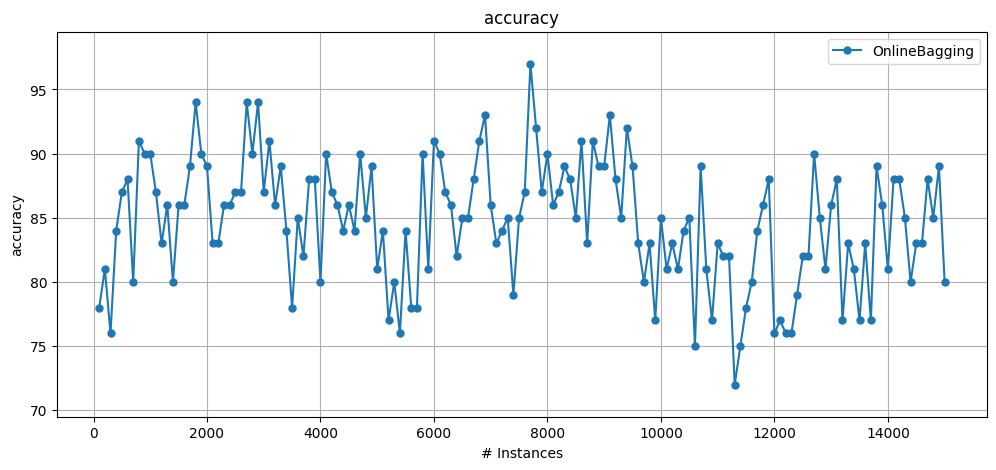

In [2]:
from capymoa.classifier import OnlineBagging
from capymoa.stream import MOAStream
from moa.streams import ConceptDriftStream

stream_sea2drift = MOAStream(
    moa_stream=ConceptDriftStream(),
    CLI="-s (ConceptDriftStream -s (generators.SEAGenerator -f 1) -d (generators.SEAGenerator -f 2) -p 5000 -w 1) -d (generators.SEAGenerator -f 3) -p 10000 -w 2000",
)

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(
    stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000
)

plot_windowed_results(results_sea2drift_OB, metric="accuracy")

### 4.2.2 DriftStream `position` + `width`

* Specifying drift location using the *first* version.
* We can use either position + width or start + end to define GradualDrifts in this approach.

  ```sh
  GradualDrift(position=10000, width=2000)
  ```
  or
  ```sh
  GradualDrift(start=9000, end=12000)
  ```
* **Important**: meta-data about the specified Drifts is accessible from the stream object.

```python
print(f'The definition of the DriftStream is accessible through the object:\n {stream_sea2drift}')
```

* Furthermore, this meta-data is interpreted by the `plot_windowed_results` function producing plots that automatically indicates drift locations. 

The definition of the DriftStream is accessible through the object:
 SEA(function=1),AbruptDrift(position=5000),SEA(function=3),GradualDrift(position=10000, start=9000, end=11000, width=2000),SEA(function=1)


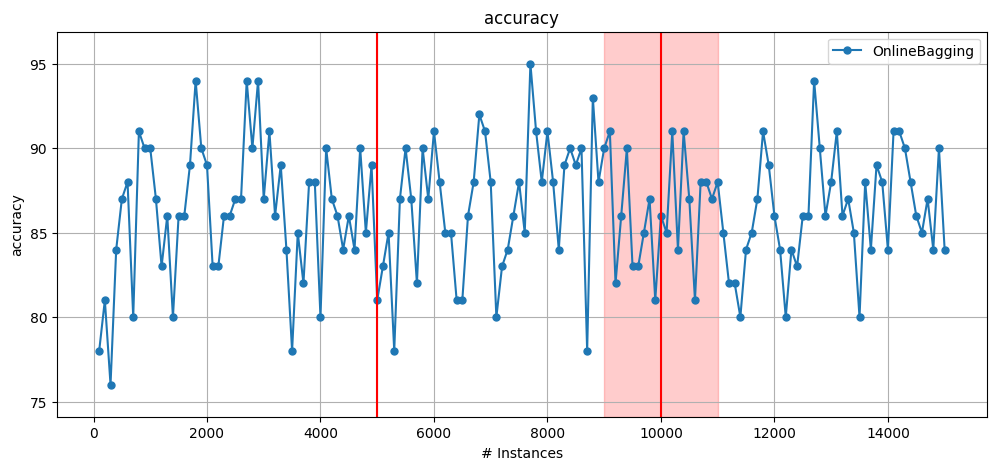

In [3]:
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.stream.generator import SEA

stream_sea2drift = DriftStream(
    stream=[
        SEA(function=1),
        AbruptDrift(position=5000),
        SEA(function=3),
        GradualDrift(position=10000, width=2000),
        # GradualDrift(start=9000, end=12000),
        SEA(function=1),
    ]
)

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(
    stream=stream_sea2drift, learner=OB, window_size=100, max_instances=15000
)

print(
    f"The definition of the DriftStream is accessible through the object:\n {stream_sea2drift}"
)
plot_windowed_results(results_sea2drift_OB, metric="accuracy")

### 4.2.3 Obtaining metadata about drift from a MOA Stream

* Besides composing a drifting stream, the `DriftStream` object also holds information about the drifts. 
* The metadata about the drifts can be used for quickly investigating where and how many `Drifts` a particular `Stream` object has associated with it.
* It is doable to extract drifting information from the MOA `ConceptDriftStream` objects, precisely the `Stream` objects that form the concepts for a proper printing. However, that has not been implemented yet as it is a bit cumbersome. So, for the moment, when a `DriftStream` is specified based on a MOA CLI, we just return the CLI used when we attempt to print the object (see below).

```python
print(stream_sea2drift)
```

* However, the information is available and can be accessed through the `get_drifts()` method as shown below:

```python
for drift in stream_sea2drift.get_drifts():
    print(f'\t{drift}')
```

Attempting to print a stream from a raw MOA ConceptDriftStream: ConceptDriftStream -s (ConceptDriftStream -s generators.SEAGenerator -d (generators.SEAGenerator -f 3) -p 5000 -w 1)                                 -d generators.SEAGenerator -w 200 -p 10000 -r 1 -a 0.0

Now, an example on how to access individual drifts from a DriftStream:
	AbruptDrift(position=5000)
	GradualDrift(position=10000, width=200)


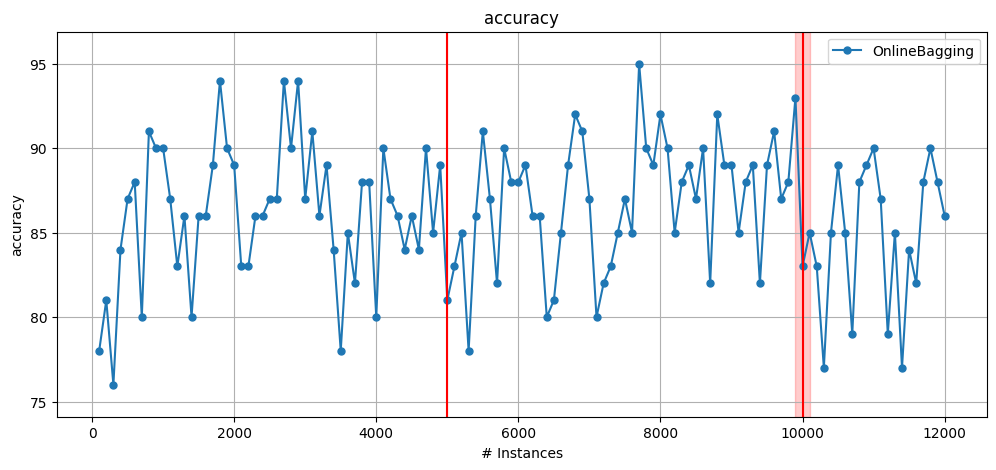

In [4]:
from moa.streams import ConceptDriftStream

stream_sea2drift = DriftStream(
    moa_stream=ConceptDriftStream(),
    CLI="-s (ConceptDriftStream -s generators.SEAGenerator -d (generators.SEAGenerator -f 3) -p 5000 -w 1) \
                                -d generators.SEAGenerator -w 200 -p 10000 -r 1 -a 0.0",
)

OB = OnlineBagging(schema=stream_sea2drift.get_schema(), ensemble_size=10)

results_sea2drift_OB = prequential_evaluation(
    stream=stream_sea2drift, learner=OB, window_size=100, max_instances=12000
)

print(
    f"Attempting to print a stream from a raw MOA ConceptDriftStream: {stream_sea2drift}"
)
print("\nNow, an example on how to access individual drifts from a DriftStream:")
for drift in stream_sea2drift.get_drifts():
    print(f"\t{drift}")
# Notice it works just fine to plot and use the DriftStream created using a MOA object.
plot_windowed_results(results_sea2drift_OB, metric="accuracy")

### 4.2.4 DriftStream ```range``` 

* This version of the DriftStream builder uses the concept of specfying the number of instances in each concept and drift, i.e. ```concept num_instances``` and ```drift num_instances```

* Still under development! Come back later :)
<div style="text-align:center">
  <img src="under_construction.jpeg" alt="alt text" width="300" height="300">
</div>


## 4.3 RecurrentConceptDriftStream 

### 4.3.1 Generate a stream with recurrent concepts

Recurrent concept stream CapyMOA:
RTG(),AbruptDrift(position=2000),RTG(tree_random_seed=2),AbruptDrift(position=4000),RTG(tree_random_seed=3),AbruptDrift(position=6000),RTG(instance_random_seed=2),AbruptDrift(position=8000),RTG(instance_random_seed=2, tree_random_seed=2),AbruptDrift(position=10000),RTG(instance_random_seed=2, tree_random_seed=3)
Recurrent concept stream MOA CLI:
 -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -d (generators.RandomTreeGenerator -r 2) -p 2000 -w 0) -d (generators.RandomTreeGenerator -r 3) -p 4000 -w 0) -d (generators.RandomTreeGenerator -i 2) -p 6000 -w 0) -d (generators.RandomTreeGenerator -r 2 -i 2) -p 8000 -w 0)  -d (generators.RandomTreeGenerator -r 3 -i 2) -w 0 -p 10000 -r 1 -a 0.0


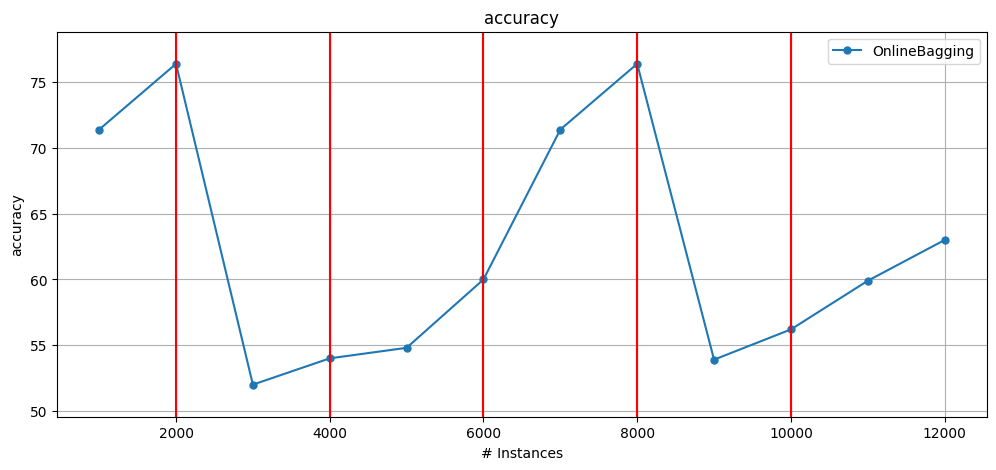

In [5]:
from capymoa.stream.drift import DriftStream, AbruptDrift
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

window_size = 1000
concept_length = 2000
max_instances = concept_length * 6

stream_with_drifts = DriftStream(
    stream=[
        RandomTreeGenerator(tree_random_seed=1),
        AbruptDrift(position=concept_length * 1),
        RandomTreeGenerator(tree_random_seed=2),
        AbruptDrift(position=concept_length * 2),
        RandomTreeGenerator(tree_random_seed=3),
        AbruptDrift(position=concept_length * 3),
        RandomTreeGenerator(tree_random_seed=1, instance_random_seed=2),
        AbruptDrift(position=concept_length * 4),
        RandomTreeGenerator(tree_random_seed=2, instance_random_seed=2),
        AbruptDrift(position=concept_length * 5),
        RandomTreeGenerator(tree_random_seed=3, instance_random_seed=2),
    ]
)

OB = OnlineBagging(schema=stream_with_drifts.get_schema(), ensemble_size=10)

results_stream_with_drifts_OB = prequential_evaluation(
    stream=stream_with_drifts,
    learner=OB,
    window_size=window_size,
    max_instances=max_instances,
)

print(f"Recurrent concept stream CapyMOA:\n{stream_with_drifts}")
print(f"Recurrent concept stream MOA CLI:\n{stream_with_drifts._CLI}")
plot_windowed_results(results_stream_with_drifts_OB, metric="accuracy")

### 4.3.2 Use recurrent concept drift API to generate recurrent concepts
* The API adds concept meta information for plotting which is not available in the previous example. 

Recurrent concept stream CapyMOA:
RTG(),AbruptDrift(position=2000),RTG(tree_random_seed=2),AbruptDrift(position=4000),RTG(tree_random_seed=3),AbruptDrift(position=6000),RTG(instance_random_seed=2),AbruptDrift(position=8000),RTG(instance_random_seed=2, tree_random_seed=2),AbruptDrift(position=10000),RTG(instance_random_seed=2, tree_random_seed=3)
Recurrent concept stream MOA CLI:
 -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -s (ConceptDriftStream -d (generators.RandomTreeGenerator -r 2) -p 2000 -w 0) -d (generators.RandomTreeGenerator -r 3) -p 4000 -w 0) -d (generators.RandomTreeGenerator -i 2) -p 6000 -w 0) -d (generators.RandomTreeGenerator -r 2 -i 2) -p 8000 -w 0)  -d (generators.RandomTreeGenerator -r 3 -i 2) -w 0 -p 10000 -r 1 -a 0.0


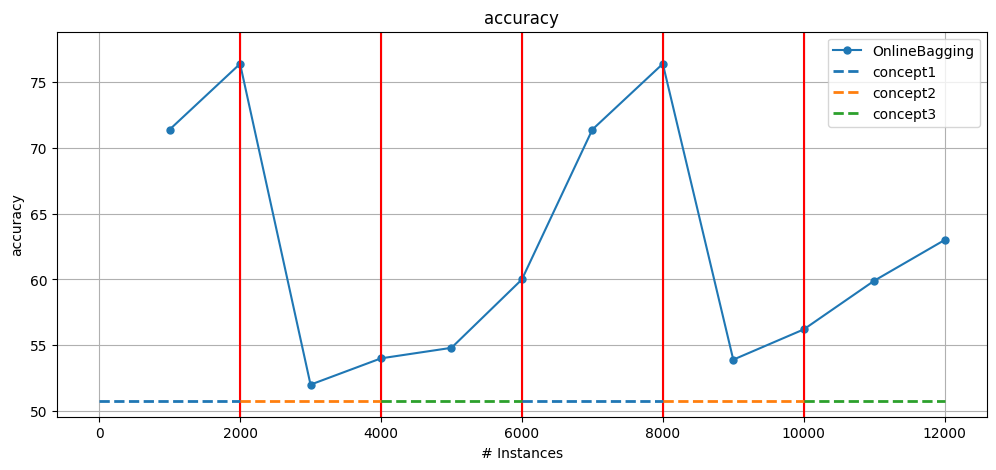

In [6]:
from capymoa.stream.drift import AbruptDrift, RecurrentConceptDriftStream
from capymoa.stream.generator import RandomTreeGenerator
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

concept1 = RandomTreeGenerator(tree_random_seed=1, instance_random_seed=1)
concept2 = RandomTreeGenerator(tree_random_seed=2, instance_random_seed=1)
concept3 = RandomTreeGenerator(tree_random_seed=3, instance_random_seed=1)

window_size = 1000
concept_length = 2000
concept_list = [concept1, concept2, concept3]
concept_name_list = ["concept1", "concept2", "concept3"]
max_recurrences_per_concept = 2
max_instances = concept_length * len(concept_list) * max_recurrences_per_concept

stream_with_recurrent_concepts = RecurrentConceptDriftStream(
    concept_list=concept_list,
    max_recurrences_per_concept=max_recurrences_per_concept,
    transition_type_template=AbruptDrift(position=concept_length),
    concept_name_list=concept_name_list,
)

OB = OnlineBagging(schema=stream_with_recurrent_concepts.get_schema(), ensemble_size=10)

results_stream_with_drifts_OB = prequential_evaluation(
    stream=stream_with_recurrent_concepts,
    learner=OB,
    window_size=window_size,
    max_instances=max_instances,
)

print(f"Recurrent concept stream CapyMOA:\n{stream_with_recurrent_concepts}")
print(f"Recurrent concept stream MOA CLI:\n{stream_with_recurrent_concepts._CLI}")

plot_windowed_results(results_stream_with_drifts_OB, metric="accuracy")